Variant B — GAN (Generative Adversarial Network)

Data Collection and preparation

In [1]:
import random
import torch


random.seed(3773)
torch.manual_seed(3773)
torch.cuda.manual_seed(3773)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


MNIST

In [2]:
import os


DATA_DIR = "./data"
OUT_DIR = "./gan_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

DATASET = "mnist"
IMG_SIZE = 32
if DATASET == "mnist":
    IMG_CHANNELS = 1
else:
    IMG_CHANNELS = 3

Z_DIM = 128
G_BASE = 128
D_BASE = 64
BATCH_SIZE = 128

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


if DATASET == "mnist":
    tfm = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])
    train_set = datasets.MNIST(root=DATA_DIR, train=True, transform=tfm, download=True)
else:
    raise ValueError("We'll start with MNIST. We'll switch to CIFAR-10 later.")

loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print(len(train_set))

100%|██████████| 9.91M/9.91M [00:20<00:00, 495kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 164kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.04MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.82MB/s]

60000


Design and implement two neural networks: Generator and Discriminator.

In [4]:
import torch.nn as nn


def g_block(in_ch, out_ch, kernel=4, stride=2, padding=1, use_bn=True):
    layers = []
    convt = nn.ConvTranspose2d(in_ch, out_ch, kernel, stride, padding, bias=False)
    layers.append(convt)

    if use_bn:
        layers.append(nn.BatchNorm2d(out_ch))
    
    layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

def d_block(in_ch, out_ch, kernel=4, stride=2, padding=1, use_bn=True):
    layers = []
    conv = nn.Conv2d(in_ch, out_ch, kernel, stride, padding, bias=False)
    layers.append(conv)

    if use_bn:
        layers.append(nn.BatchNorm2d(out_ch))
    
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self, z_dim=128, img_channels=1, base=128):
        super().__init__()

        self.net = nn.Sequential(
            # Input: z -> (base*8) x 4 x 4
            nn.ConvTranspose2d(z_dim, base * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base * 8),
            nn.ReLU(inplace=True),

            # 4x4 -> 8x8
            nn.ConvTranspose2d(base * 8, base * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base * 4),
            nn.ReLU(inplace=True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(base * 4, base * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base * 2),
            nn.ReLU(inplace=True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(base * 2, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.net(z)
        return out   

class Discriminator(nn.Module):
    def __init__(self, img_channels=1, base=64, use_bn=True):
        super().__init__()

        layers = []
        # 32x32 -> 16x16
        layers.append(nn.Conv2d(img_channels, base, 4, 2, 1, bias=False))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # 16x16 -> 8x8
        block1 = d_block(base, base * 2, use_bn=use_bn)
        layers.append(block1)

        # 8x8 -> 4x4
        block2 = d_block(base * 2, base * 4, use_bn=use_bn)
        layers.append(block2)

        # 4x4 -> 1x1
        layers.append(nn.Conv2d(base * 4, 1, 4, 1, 0, bias=False))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.net(x).view(-1)
        return logits

def weights_init_dcgan(m):
    name = m.__class__.__name__

    if "Conv" in name and hasattr(m, "weight"):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    
    if "BatchNorm" in name:
        if hasattr(m, "weight") and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

In [5]:
G = Generator(Z_DIM, IMG_CHANNELS, G_BASE).to(device)
D = Discriminator(IMG_CHANNELS, D_BASE, use_bn=True).to(device)

G.apply(weights_init_dcgan)
D.apply(weights_init_dcgan)

print(G)
print(D)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(

In [6]:
with torch.no_grad():
    z = torch.randn(8, Z_DIM, 1, 1, device=device)
    fake = G(z)
    logits = D(fake)

    print("Fake shapes:", tuple(fake.shape))
    print("Logits shape:", tuple(logits.shape))

    if fake.shape[2] != IMG_SIZE or fake.shape[3] != IMG_SIZE:
        raise RuntimeError("The generator does not produce an image of the required size.")

Fake shapes: (8, 1, 32, 32)
Logits shape: (8,)


Train the GAN on MNIST or CIFAR-10

In [7]:
import torch.optim as optim


EPOCHS = 50
LR = 2e-4
BETA1 = 0.5
BETA2 = 0.999
LABEL_SMOOTH = 0.9

criterion = nn.BCEWithLogitsLoss()

opt_G = optim.Adam(G.parameters(), lr=LR, betas=(BETA1, BETA2))
opt_D = optim.Adam(D.parameters(), lr=LR, betas=(BETA1, BETA2))

scheduler_G = optim.lr_scheduler.StepLR(opt_G, step_size=20, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(opt_D, step_size=20, gamma=0.5)

In [8]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils


METRICS_CSV = os.path.join(OUT_DIR, "gan_metrics.csv")
CKPT = os.path.join(OUT_DIR, "gan_checkpoint.pt")

if not os.path.exists(METRICS_CSV):
    with open(METRICS_CSV, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "G_loss", "D_loss"])

G.train()
D.train()

fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=device)
G_losses = []
D_losses = []

for epoch in range(EPOCHS):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0

    for real, _ in loader:
        real = real.to(device)
        bs = real.size(0)


        noise = torch.randn(bs, Z_DIM, 1, 1, device=device)
        fake = G(noise)

        real_labels = torch.full((bs,), LABEL_SMOOTH, device=device)
        fake_labels = torch.full((bs,), 0.0, device=device)

        D_real = D(real)
        D_fake = D(fake.detach())

        loss_real = criterion(D_real, real_labels)
        loss_fake = criterion(D_fake, fake_labels)
        D_loss = loss_real + loss_fake

        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()


        fake_labels_G = torch.full((bs,), 1.0, device=device)
        D_fake_for_G = D(fake)
        G_loss = criterion(D_fake_for_G, fake_labels_G)

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

        g_loss_epoch += G_loss.item()
        d_loss_epoch += D_loss.item()
    
    scheduler_G.step()
    scheduler_D.step()

    avg_g = g_loss_epoch / len(loader)
    avg_d = d_loss_epoch / len(loader)
    G_losses.append(avg_g)
    D_losses.append(avg_d)

    print(f"Epoch [{epoch+1}/{EPOCHS}] D_losses: {avg_d:.4f} | G_losses: {avg_g:.4f}")

    if (epoch + 1) % 5 == 0:
        G.eval()
        with torch.no_grad():
            fake_imgs = G(fixed_noise).cpu()
        grid = utils.make_grid(fake_imgs, nrow=8, normalize=True)
        plt.figure(figsize=(6,6))
        plt.imshow(np.transpose(grid, (1,2,0)))
        plt.axis("off")
        plt.title(f"Generated images at epoch {epoch+1}")
        plt.show()
        
        utils.save_image(fake_imgs, f"{OUT_DIR}/fake_epoch_{epoch+1}.png", nrow=8, normalize=True)
        G.train()

    with open(METRICS_CSV, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, avg_g, avg_d])

    checkpoint = {
        "epoch": epoch + 1,
        "G_state": G.state_dict(),
        "D_state": D.state_dict(),
        "opt_G_state": opt_G.state_dict(),
        "opt_D_state": opt_D.state_dict(),
        "G_losses": G_losses,
        "D_losses": D_losses,
        "fixed_noise": fixed_noise.detach().cpu()
    }
    torch.save(checkpoint, CKPT)   

KeyboardInterrupt: 

Analyze the quality and diversity of generated samples.

   epoch    G_loss    D_loss
0      1  2.828970  0.829366
1      2  1.916842  0.890274
2      3  2.004263  0.865062
3      4  2.202013  0.785024
4      5  2.368043  0.764921


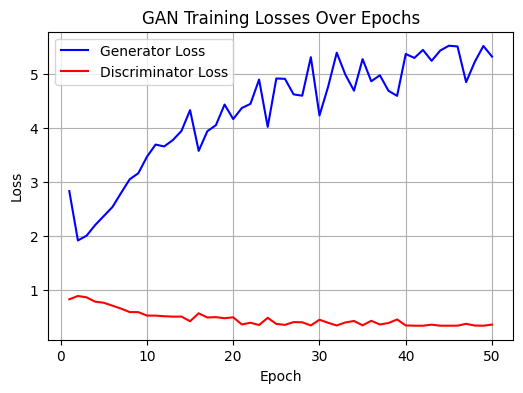

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from PIL import Image
import numpy as np
import os

metrics_path = os.path.join(OUT_DIR, "gan_metrics.csv")
if os.path.exists(metrics_path):
    df = pd.read_csv(metrics_path)
    print(df.head())

plt.figure(figsize=(6, 4))
plt.plot(df["epoch"], df["G_loss"], label="Generator Loss", color='blue')
plt.plot(df["epoch"], df["D_loss"], label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


files = sorted(glob.glob(f"{OUT_DIR}/fake_epoch_*.png"))

Mean |deltaD_loss|: 0.0457
Mean |deltaG_loss|: 0.3313
Training stable — no major oscillations.


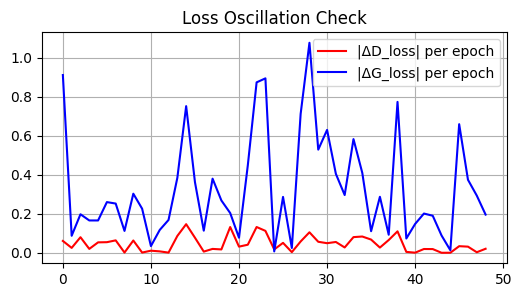

In [9]:
d_diff = np.abs(np.diff(df["D_loss"]))
g_diff = np.abs(np.diff(df["G_loss"]))

print(f"Mean |deltaD_loss|: {d_diff.mean():.4f}")
print(f"Mean |deltaG_loss|: {g_diff.mean():.4f}")

if d_diff.mean() < 0.2 and g_diff.mean() < 0.5:
    print("Training stable — no major oscillations.")
else:
    print("Training instability detected — possible gradient fluctuations.")

plt.figure(figsize=(6, 3))
plt.plot(d_diff, label="|ΔD_loss| per epoch", color='red')
plt.plot(g_diff, label="|ΔG_loss| per epoch", color='blue')
plt.legend()
plt.title("Loss Oscillation Check")
plt.grid(True)
plt.show()

CIFAR

In [8]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader


DATASET = "cifar10"
IMG_SIZE = 32
IMG_CHANNELS = 3
BATCH_SIZE = 128

DATA_DIR = "./data"
OUT_DIR_CIFAR = "./gan_outputs_cifar"
os.makedirs(OUT_DIR_CIFAR, exist_ok=True)

tfm_cifar = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_set_cifar = datasets.CIFAR10(root=DATA_DIR, train=True, transform=tfm_cifar, download=True)
loader_cifar = DataLoader(train_set_cifar, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print(len(train_set_cifar))

100%|██████████| 170M/170M [01:15<00:00, 2.27MB/s] 


50000


In [9]:
G_CIFAR = Generator(Z_DIM, IMG_CHANNELS, G_BASE).to(device)
D_CIFAR = Discriminator(IMG_CHANNELS, D_BASE, use_bn=True).to(device)

G_CIFAR.apply(weights_init_dcgan)
D_CIFAR.apply(weights_init_dcgan)

print(G_CIFAR)
print(D_CIFAR)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(

In [10]:
EPOCHS_CIFAR = 50
LR = 2e-4
BETA1 = 0.5
BETA2 = 0.999
LABEL_SMOOTH = 0.9

criterion = nn.BCEWithLogitsLoss()
opt_G_cifar = optim.Adam(G_CIFAR.parameters(), lr=LR, betas=(BETA1, BETA2))
opt_D_cifar = optim.Adam(D_CIFAR.parameters(), lr=LR, betas=(BETA1, BETA2))

scheduler_G_cifar = optim.lr_scheduler.StepLR(opt_G_cifar, step_size=20, gamma=0.5)
scheduler_D_cifar = optim.lr_scheduler.StepLR(opt_D_cifar, step_size=20, gamma=0.5)

In [13]:
METRICS_CSV_CIFAR = os.path.join(OUT_DIR_CIFAR, "gan_metrics_cifar.csv")
CKPT_CIFAR = os.path.join(OUT_DIR_CIFAR, "gan_checkpoint_cifar.pt")

if not os.path.exists(METRICS_CSV_CIFAR):
    with open(METRICS_CSV_CIFAR, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "G_loss", "D_loss"])

[CIFAR] Epoch [1/50] D_loss=0.8561 | G_loss=3.8669
[CIFAR] Epoch [2/50] D_loss=0.9227 | G_loss=2.5794
[CIFAR] Epoch [3/50] D_loss=0.8887 | G_loss=2.5979
[CIFAR] Epoch [4/50] D_loss=0.9720 | G_loss=2.3194
[CIFAR] Epoch [5/50] D_loss=0.8410 | G_loss=2.5437


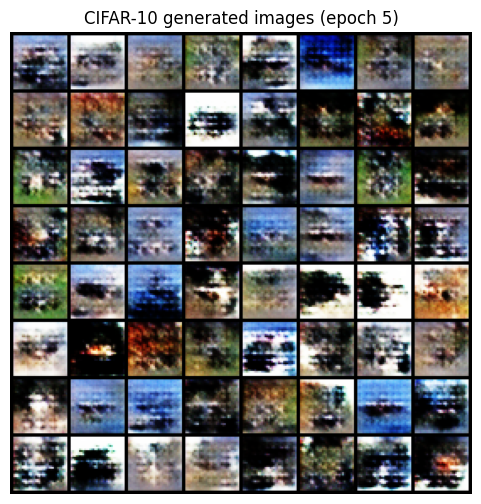

[CIFAR] Epoch [6/50] D_loss=0.8211 | G_loss=2.4996
[CIFAR] Epoch [7/50] D_loss=0.9646 | G_loss=2.3101
[CIFAR] Epoch [8/50] D_loss=0.9857 | G_loss=2.1417
[CIFAR] Epoch [9/50] D_loss=0.9742 | G_loss=2.1007
[CIFAR] Epoch [10/50] D_loss=0.9427 | G_loss=2.0799


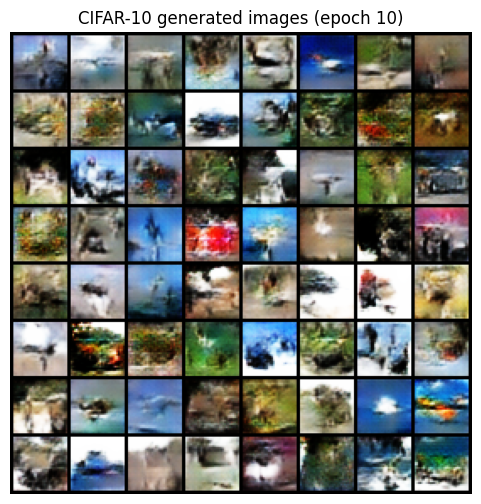

[CIFAR] Epoch [11/50] D_loss=1.0208 | G_loss=1.9482
[CIFAR] Epoch [12/50] D_loss=0.9640 | G_loss=2.0300
[CIFAR] Epoch [13/50] D_loss=0.9712 | G_loss=2.0513
[CIFAR] Epoch [14/50] D_loss=0.9341 | G_loss=1.9780
[CIFAR] Epoch [15/50] D_loss=0.9337 | G_loss=1.9744


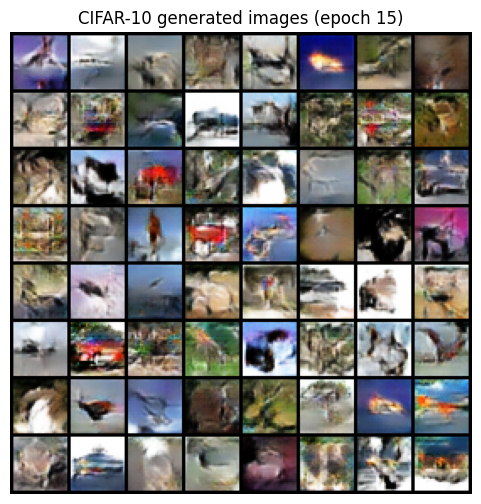

[CIFAR] Epoch [16/50] D_loss=0.9744 | G_loss=1.9250
[CIFAR] Epoch [17/50] D_loss=0.9836 | G_loss=1.9257
[CIFAR] Epoch [18/50] D_loss=0.9777 | G_loss=1.8721
[CIFAR] Epoch [19/50] D_loss=1.0389 | G_loss=1.8176
[CIFAR] Epoch [20/50] D_loss=0.9921 | G_loss=1.8245


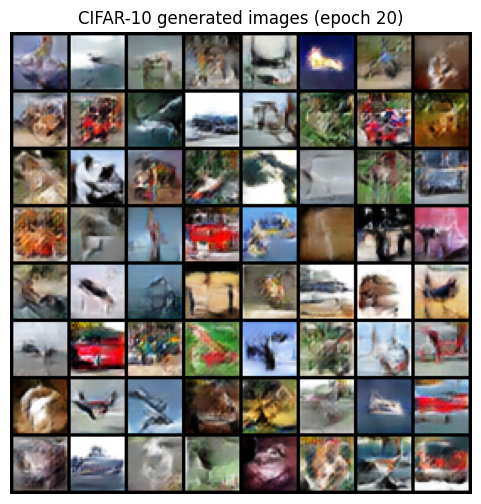

[CIFAR] Epoch [21/50] D_loss=0.8842 | G_loss=1.6022
[CIFAR] Epoch [22/50] D_loss=0.8732 | G_loss=1.7073
[CIFAR] Epoch [23/50] D_loss=0.8813 | G_loss=1.7556
[CIFAR] Epoch [24/50] D_loss=0.8780 | G_loss=1.7979
[CIFAR] Epoch [25/50] D_loss=0.8897 | G_loss=1.8031


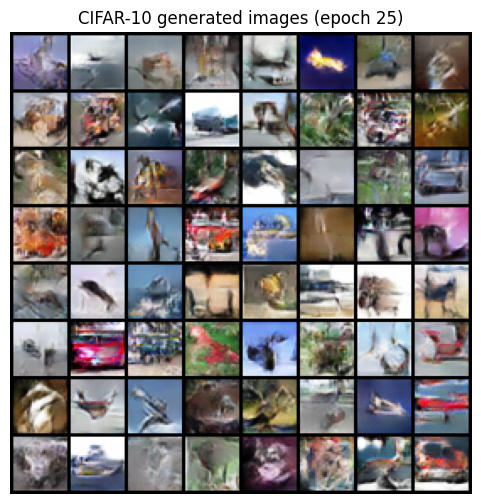

[CIFAR] Epoch [26/50] D_loss=0.8536 | G_loss=1.8491
[CIFAR] Epoch [27/50] D_loss=0.8971 | G_loss=1.8427
[CIFAR] Epoch [28/50] D_loss=0.8431 | G_loss=1.8680
[CIFAR] Epoch [29/50] D_loss=0.8915 | G_loss=1.8642
[CIFAR] Epoch [30/50] D_loss=0.8742 | G_loss=1.8558


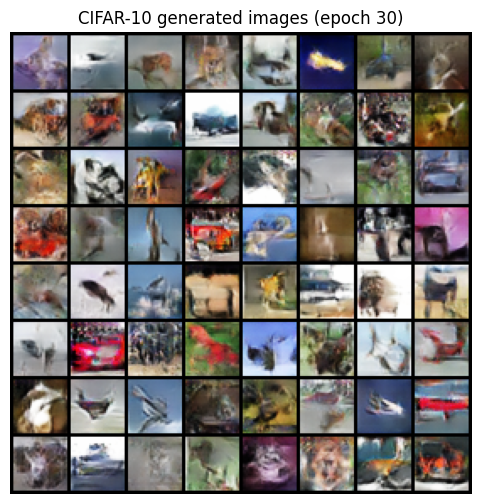

[CIFAR] Epoch [31/50] D_loss=0.8806 | G_loss=1.8674
[CIFAR] Epoch [32/50] D_loss=0.8417 | G_loss=1.8706
[CIFAR] Epoch [33/50] D_loss=0.8906 | G_loss=1.8712
[CIFAR] Epoch [34/50] D_loss=0.8833 | G_loss=1.8985
[CIFAR] Epoch [35/50] D_loss=0.9042 | G_loss=1.8662


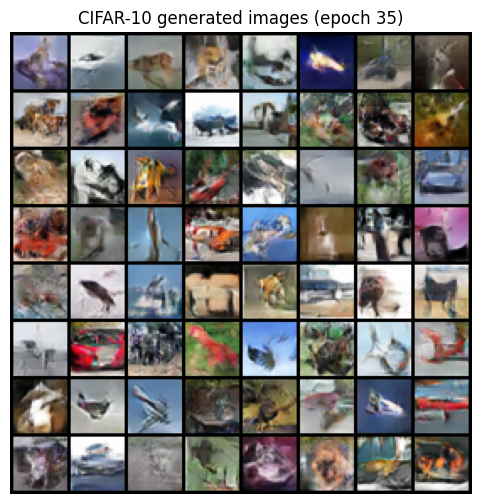

[CIFAR] Epoch [36/50] D_loss=0.8639 | G_loss=1.8880
[CIFAR] Epoch [37/50] D_loss=0.8774 | G_loss=1.8913
[CIFAR] Epoch [38/50] D_loss=0.9061 | G_loss=1.8809
[CIFAR] Epoch [39/50] D_loss=0.8622 | G_loss=1.8757
[CIFAR] Epoch [40/50] D_loss=0.8852 | G_loss=1.8914


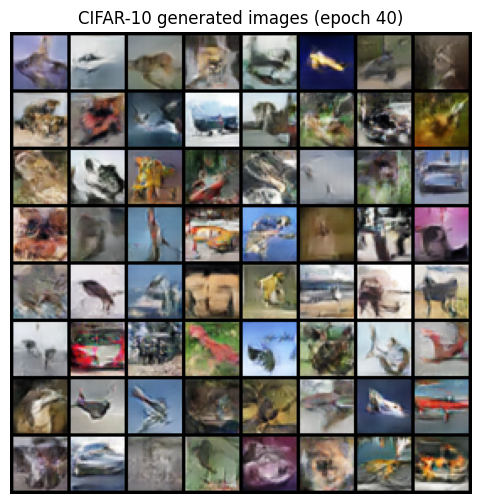

[CIFAR] Epoch [41/50] D_loss=0.8091 | G_loss=1.6985
[CIFAR] Epoch [42/50] D_loss=0.8076 | G_loss=1.7248
[CIFAR] Epoch [43/50] D_loss=0.8041 | G_loss=1.7625
[CIFAR] Epoch [44/50] D_loss=0.8082 | G_loss=1.7867
[CIFAR] Epoch [45/50] D_loss=0.7976 | G_loss=1.8104


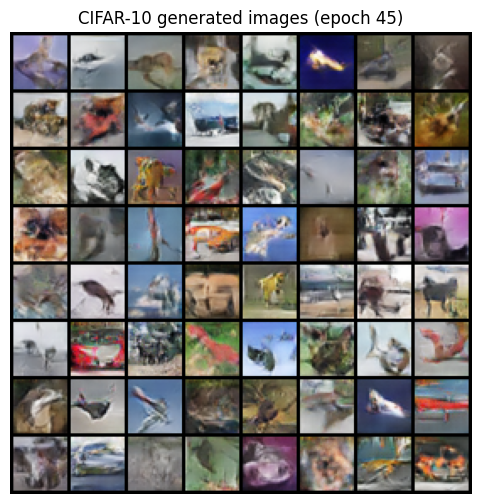

[CIFAR] Epoch [46/50] D_loss=0.8006 | G_loss=1.8500
[CIFAR] Epoch [47/50] D_loss=0.7953 | G_loss=1.8404
[CIFAR] Epoch [48/50] D_loss=0.7851 | G_loss=1.8612
[CIFAR] Epoch [49/50] D_loss=0.7798 | G_loss=1.8736
[CIFAR] Epoch [50/50] D_loss=0.7738 | G_loss=1.8803


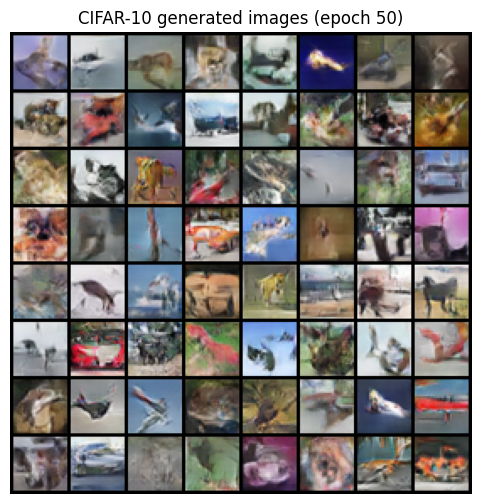

In [ ]:
G_CIFAR.train()
D_CIFAR.train()

fixed_noise_cifar = torch.randn(64, Z_DIM, 1, 1, device=device)
G_losses_cifar, D_losses_cifar = [], []

for epoch in range(EPOCHS_CIFAR):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0

    for real, _ in loader_cifar:
        real = real.to(device)
        bs = real.size(0)
        
        noise = torch.randn(bs, Z_DIM, 1, 1, device=device)
        fake = G_CIFAR(noise)

        real_labels = torch.full((bs,), LABEL_SMOOTH, device=device)
        fake_labels = torch.full((bs,), 0.0, device=device)

        D_real = D_CIFAR(real)
        D_fake = D_CIFAR(fake.detach())

        loss_real = criterion(D_real, real_labels)
        loss_fake = criterion(D_fake, fake_labels)
        D_loss = loss_real + loss_fake

        opt_D_cifar.zero_grad()
        D_loss.backward()
        opt_D_cifar.step()

        fake_labels_G = torch.full((bs,), 1.0, device=device)
        D_fake_for_G = D_CIFAR(fake)
        G_loss = criterion(D_fake_for_G, fake_labels_G)

        opt_G_cifar.zero_grad()
        G_loss.backward()
        opt_G_cifar.step()

        g_loss_epoch += G_loss.item()
        d_loss_epoch += D_loss.item()
    
    scheduler_G_cifar.step()
    scheduler_D_cifar.step()

    avg_g = g_loss_epoch / len(loader_cifar)
    avg_d = d_loss_epoch / len(loader_cifar)
    G_losses_cifar.append(avg_g)
    D_losses_cifar.append(avg_d)

    print(f"[CIFAR] Epoch [{epoch+1}/{EPOCHS_CIFAR}] D_loss={avg_d:.4f} | G_loss={avg_g:.4f}")

    if (epoch + 1) % 5 == 0:
        G_CIFAR.eval()
        with torch.no_grad():
            fake_imgs = G_CIFAR(fixed_noise_cifar).cpu()
        grid = utils.make_grid(fake_imgs, nrow=8, normalize=True)
        plt.figure(figsize=(6, 6))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis("off")
        plt.title(f"CIFAR-10 generated images (epoch {epoch+1})")
        plt.show()
        utils.save_image(fake_imgs, f"{OUT_DIR_CIFAR}/fake_epoch_{epoch+1}.png", nrow=8, normalize=True)
        G_CIFAR.train()

        with open(METRICS_CSV_CIFAR, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, avg_g, avg_d])
        
        checkpoint = {
            "epoch": epoch + 1,
            "G_state": G_CIFAR.state_dict(),
            "D_state": D_CIFAR.state_dict(),
            "opt_G_state":  opt_G_cifar.state_dict(),
            "opt_D_state": opt_D_cifar.state_dict(),
            "G_losses": G_losses_cifar,
            "D_losses": D_losses_cifar
        }
        torch.save(checkpoint, CKPT_CIFAR)

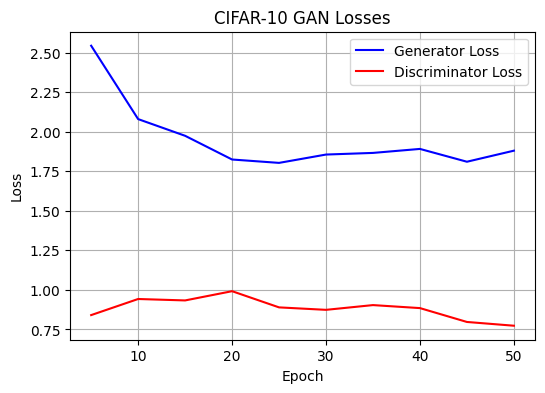

In [14]:
df_cifar = pd.read_csv(METRICS_CSV_CIFAR)
plt.figure(figsize=(6, 4))
plt.plot(df_cifar["epoch"], df_cifar["G_loss"], label="Generator Loss", color='blue')
plt.plot(df_cifar["epoch"], df_cifar["D_loss"], label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR-10 GAN Losses")
plt.legend()
plt.grid(True)
plt.show()

Discriminator thinks:
 - Real image: 0.499
 - Generated image: 0.505


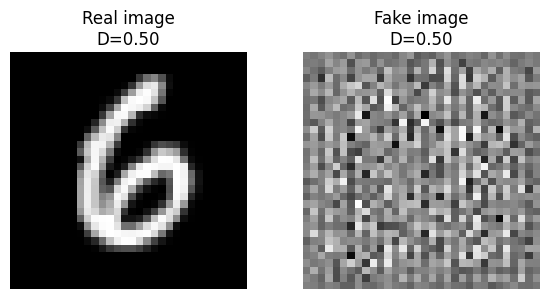

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np


G.eval()
D.eval()

real_img, _ = next(iter(loader))
real_img = real_img[:1].to(device)

with torch.no_grad():
    D_real_out = torch.sigmoid(D(real_img)).item()

z = torch.randn(1, Z_DIM, 1, 1, device=device)
with torch.no_grad():
    fake_img = G(z)
    D_fake_out = torch.sigmoid(D(fake_img)).item()

print(f"Discriminator thinks:")
print(f" - Real image: {D_real_out:.3f}")
print(f" - Generated image: {D_fake_out:.3f}")

real_np = (real_img.cpu().squeeze().numpy() + 1) / 2
fake_np = (fake_img.cpu().squeeze().numpy() + 1) / 2

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(real_np, cmap='gray')
axs[0].set_title(f"Real image\nD={D_real_out:.2f}")
axs[0].axis('off')

axs[1].imshow(fake_np, cmap='gray')
axs[1].set_title(f"Fake image\nD={D_fake_out:.2f}")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Discriminator thinks:
 - Real image: 0.511
 - Generated image: 0.501


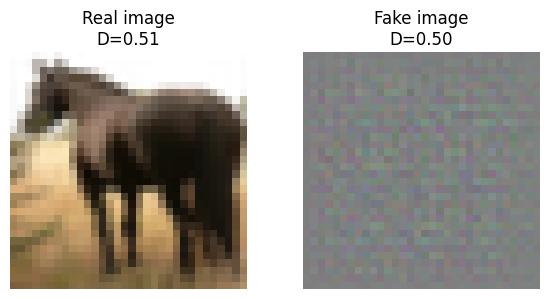

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np


G_CIFAR.eval()
D_CIFAR.eval()

real_img, _ = next(iter(loader_cifar))
real_img = real_img[:1].to(device)

with torch.no_grad():
    D_real_out = torch.sigmoid(D_CIFAR(real_img)).item()

z = torch.randn(1, Z_DIM, 1, 1, device=device)
with torch.no_grad():
    fake_img = G_CIFAR(z)
    D_fake_out = torch.sigmoid(D_CIFAR(fake_img)).item()

print(f"Discriminator thinks:")
print(f" - Real image: {D_real_out:.3f}")
print(f" - Generated image: {D_fake_out:.3f}")

real_np = (np.transpose(real_img.cpu().squeeze().numpy(), (1, 2, 0)) + 1) / 2
fake_np = (np.transpose(fake_img.cpu().squeeze().numpy(), (1, 2, 0)) + 1) / 2

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(real_np)
axs[0].set_title(f"Real image\nD={D_real_out:.2f}")
axs[0].axis('off')

axs[1].imshow(fake_np)
axs[1].set_title(f"Fake image\nD={D_fake_out:.2f}")
axs[1].axis('off')

plt.tight_layout()
plt.show()